<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo Final de Máster</p>
<p style="margin: 0; text-align:right;">2020-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Consideraciones Generales

El modelo entrenado predice el consumo de batería disponible de un sensor IoT.  Para ello, el modelo se ha entrenado con datos reales de un sensor, el cual además de enviar periódicamente lecturas de la carga de batería restante también envía datos meteorológicos (temperatura, humedad y luz ambiental). 
 
 El período de captura de dataset es de 20 días y comprende del 11 al 30 de noviembre de 2020, con una frecuencia de lectura de 10 minutos.
 
En cada marca de tiempo (timestamp, en inglés) el sensor envía la siguiente información:
 
* Temperatura en grados Celsius
* Humedad relativa en porcentaje
* Intensidad de luz, unidad adimensional con valores entre 0 y 100
* Porcentaje de carga disponible de la batería

Los valores son guardados en una hoja de Google Sheets y para entrenar el modelo se han descargado en formato csv.

#Análisis y preprocesado de los datos


In [46]:
#Se instala en Google Colab la librería stldecompose
!pip install stldecompose

In [47]:
#Se importan librerías

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from stldecompose import decompose
from scipy.interpolate import interp1d
import datetime

#Se define tamaño por defecto de las imágenes
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False


In [48]:
#Se monta unidad de GoogleDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
#Se define ruta dónde se guardaran modelos generados
import os
MODELS_DIR = '/content/gdrive/My Drive/Colab Notebooks/TFM/train/models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

In [50]:
#Leemos fichero con dataset
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/TFM/train/datasets/raw_sensor_data.csv',index_col=0)

In [51]:
#Datos contenidos en el dataset
df.head()

,temp,hum,ligh,bat
published_at,,,,
2020-11-10T14:04:41.073Z,25,50,9,99.89
2020-11-10T14:36:48.595Z,25,50,9,99.72
2020-11-10T14:37:34.940Z,24,50,9,99.55
2020-11-10T14:48:01.287Z,25,50,10,99.55
2020-11-10T14:58:28.259Z,24,50,10,99.39


In [52]:
#Dimensiones del dataset
print(df.shape)

(2885, 4)


In [53]:
#Tipo de datos de las variables
df.dtypes

temp      int64
hum       int64
ligh      int64
bat     float64
dtype: object

In [54]:
#Redondeamos los timestamp al múltiplo de 10 más cercano
time = df.index.to_list()
time10 = []
for t in time:
  tm = datetime.datetime.strptime(t[:-8],'%Y-%m-%dT%H:%M')
  tm = tm - datetime.timedelta(minutes=tm.minute % 10)
  time10.append(tm)
df.index = time10
df.head()

,temp,hum,ligh,bat
2020-11-10 14:00:00,25,50,9,99.89
2020-11-10 14:30:00,25,50,9,99.72
2020-11-10 14:30:00,24,50,9,99.55
2020-11-10 14:40:00,25,50,10,99.55
2020-11-10 14:50:00,24,50,10,99.39


In [55]:
#Eliminamos los timestamp duplicados
df = df[~df.index.duplicated(keep='first')]
df.head()

,temp,hum,ligh,bat
2020-11-10 14:00:00,25,50,9,99.89
2020-11-10 14:30:00,25,50,9,99.72
2020-11-10 14:40:00,25,50,10,99.55
2020-11-10 14:50:00,24,50,10,99.39
2020-11-10 15:00:00,24,50,10,99.39


In [56]:
#Se completa el dataset con los timestamp que no sean registrado
#Se le asignan valores tipo NaN
df = df.resample('10T', origin=0).mean()
df.head()

,temp,hum,ligh,bat
2020-11-10 14:00:00,25.0,50.0,9.0,99.89
2020-11-10 14:10:00,NaN,NaN,NaN,NaN
2020-11-10 14:20:00,NaN,NaN,NaN,NaN
2020-11-10 14:30:00,25.0,50.0,9.0,99.72
2020-11-10 14:40:00,25.0,50.0,10.0,99.55


### Visualización de los datos

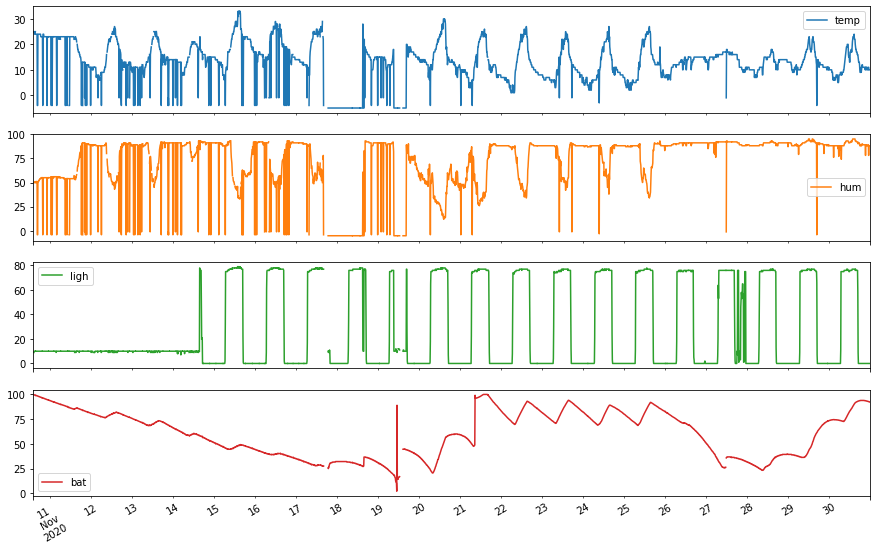

In [57]:
#Visualizamos las variables del dataset
#Se observan valores que son errores de lectura del sensor
plot_cols = ['temp', 'hum', 'ligh', 'bat']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True,figsize=(15,10))

In [58]:
#Ejemplo de error de lectura del sensor
df[14:19]

,temp,hum,ligh,bat
2020-11-10 16:20:00,24.0,51.0,10.0,98.64
2020-11-10 16:30:00,-4.0,-4.0,10.0,98.45
2020-11-10 16:40:00,-4.0,-4.0,10.0,98.45
2020-11-10 16:50:00,24.0,51.0,10.0,98.26
2020-11-10 17:00:00,24.0,51.0,10.0,98.07


In [59]:
#Encontramos cuántas lecturas hay erróneas
df[df.lt(0).any(1)]

,temp,hum,ligh,bat
2020-11-10 16:30:00,-4.0,-4.0,10.0,98.45
2020-11-10 16:40:00,-4.0,-4.0,10.0,98.45
2020-11-10 19:40:00,-4.0,-4.0,10.0,96.53
2020-11-10 22:10:00,-4.0,-4.0,10.0,94.81
2020-11-11 00:40:00,-4.0,-4.0,10.0,93.27
...,...,...,...,...
2020-11-23 10:00:00,-1.0,-1.0,75.0,77.77
2020-11-23 17:20:00,-1.0,-1.0,0.0,91.83
2020-11-24 09:20:00,-3.0,-3.0,75.0,70.06
2020-11-27 11:40:00,-1.0,-1.0,76.0,35.93


In [60]:
#Remmplaamos los valores negativos de error de lectura por valores NaN
for i in range(-5,0):
  df = df.replace(i,np.nan)

In [61]:
#Confirmamos que ahora los errores son NaN
df[14:19]

,temp,hum,ligh,bat
2020-11-10 16:20:00,24.0,51.0,10.0,98.64
2020-11-10 16:30:00,NaN,NaN,10.0,98.45
2020-11-10 16:40:00,NaN,NaN,10.0,98.45
2020-11-10 16:50:00,24.0,51.0,10.0,98.26
2020-11-10 17:00:00,24.0,51.0,10.0,98.07


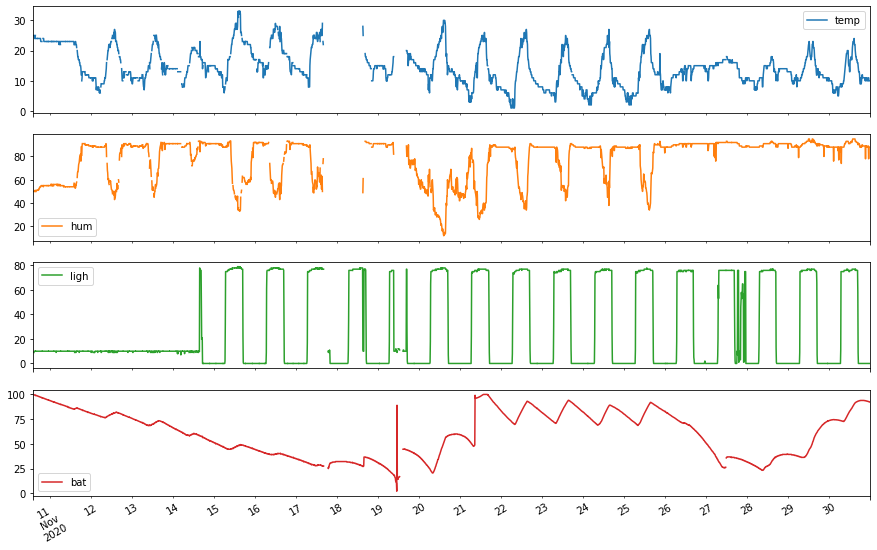

In [62]:
#Visualizamos las variables del dataset ahora con valores NaN
plot_cols = ['temp', 'hum', 'ligh', 'bat']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True,figsize=(15,10))

Para las marcas de tiempo NaN y menores a 2 horas aproximadamente se interpolaron los valores. Las secuencias más largas, se completaron con datos del día anterior.  

In [63]:
df = df.interpolate(limit=15)
df = df.groupby(df.index.time).ffill()

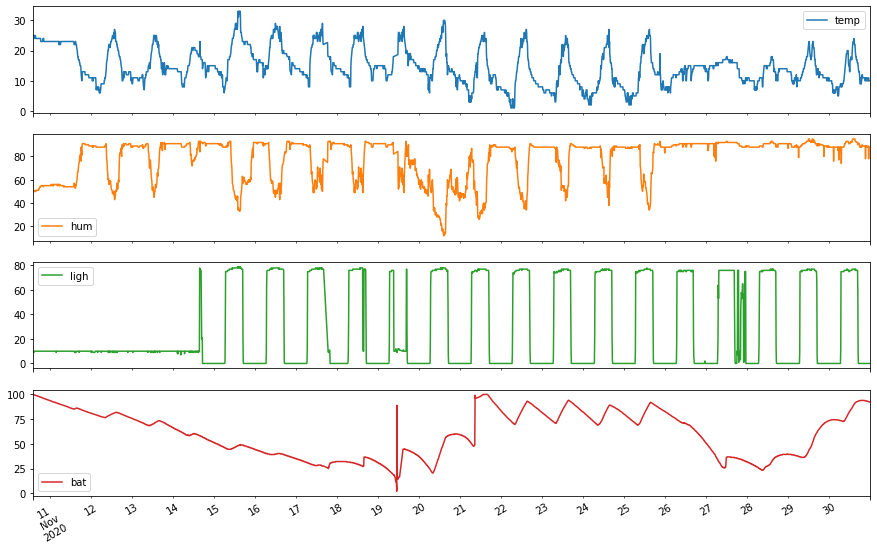

In [64]:
#Se visualiza el dataset con datos completos
plot_cols = ['temp', 'hum', 'ligh', 'bat']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True,figsize=(15,10))

### Periodicidad

la frecuencia de medidas es de 10 minutos. Esto quiere decir que para un día completo se deben obtener unas 144 muestras. Haciendo uso de la librería stldecompose y de la cantidad de muestras por día, se descomponen los datos de carga de la batería y así obtener su tendencia, estacionalidad y ruido. 

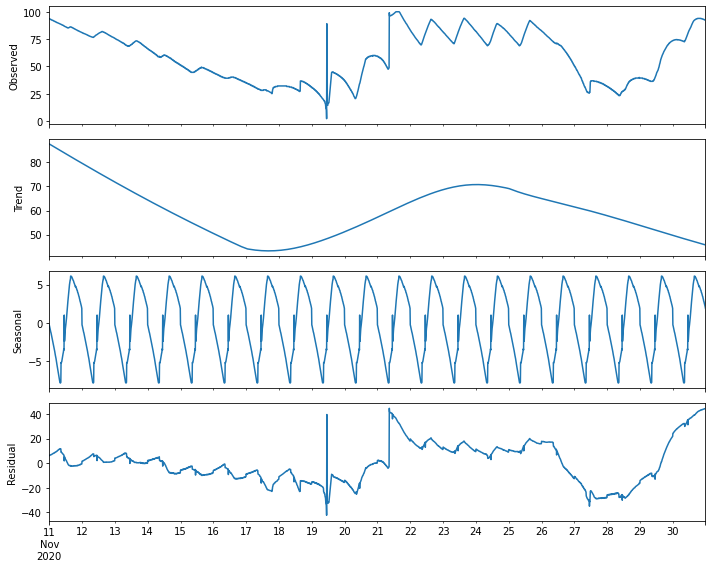

In [65]:
# Descomposición de la serie con información de la carga de batería
date_tmp = df.loc['2020-11-10'].count()
serie = df['bat'][date_tmp[3]:]
decomp = decompose(serie,period=144)
decomp.plot()
plt.show()

### Correlación entre las variables

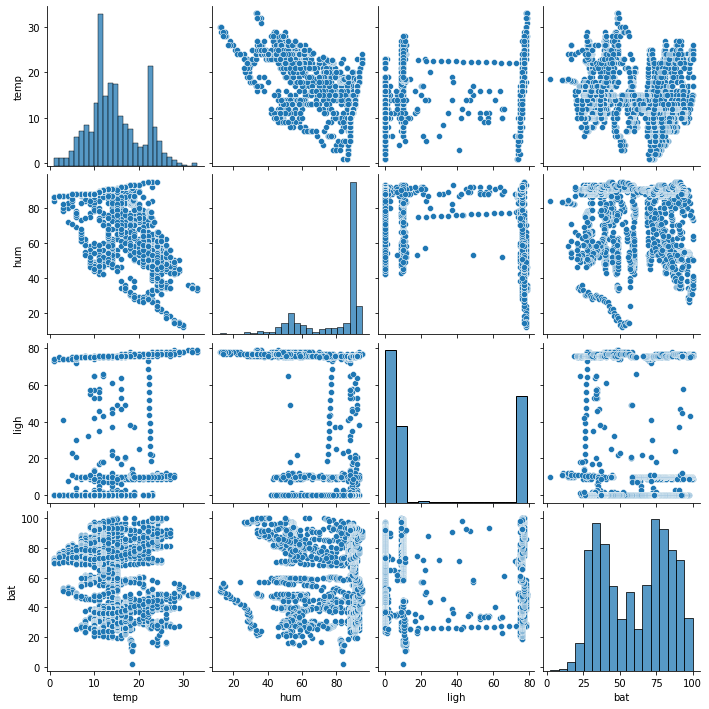

In [66]:
sns.pairplot(df)

### Creación conjuntos de train, val y test

Antes de la normalización de los datos, se separa el dataset en los conjuntos de entrenamiento, validación y prueba (denominados train, val y test).  Debido a que el dataset es una serie temporal no se pueden extraer datos de manera aleatoria para formar cada uno de los conjuntos.  En este caso, los conjuntos se deben separar de forma secuencial:
* Conjunto de entrenamiento: el primer 70% de los datos
* Conjunto de validación: el siguiente 20% de los datos
* Conjunto de prueba: el restante 10% del dataset original

In [67]:
#Se crean conjuntos de train, val y test
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [68]:
#Dimensiones de cada conjunto
print('train',train_df.shape)
print('val',val_df.shape)
print('test',test_df.shape)

train (2058, 4)
val (588, 4)
test (294, 4)


Para la normalización de los datos, se obtiene la media y la desviación estándar del conjunto de entrenamiento, que serán los mismos valores a utilizar para normalizar los conjuntos de validación y de prueba.  De esta forma se garantiza que el modelo a implementar no tiene acceso a los conjuntos de validación y de prueba.

In [69]:
#Normalización de los datos en cada conjunto
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [70]:
#Se guardan estas constantes en un fichero
train_mean.to_csv('/content/gdrive/My Drive/Colab Notebooks/TFM/train/constants/train_mean.csv')
train_std.to_csv('/content/gdrive/My Drive/Colab Notebooks/TFM/train/constants/train_std.csv')

In [71]:
#Constantes que se utilizarán para dar formato a los datos en tiempo real del sensor
print(train_mean)
print(train_std)

temp    15.682708
hum     74.237673
ligh    24.513120
bat     61.166390
dtype: float64
temp     6.314135
hum     18.820807
ligh    32.323395
bat     23.367817
dtype: float64


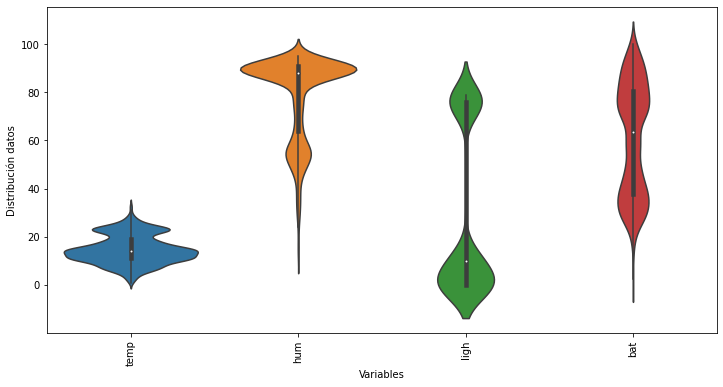

In [72]:
#Distribución de las variables del dataset
df_1 = df
df_1 = df_1.melt(var_name='Variables', value_name='Distribución datos')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Variables', y='Distribución datos', data=df_1)
_ = ax.set_xticklabels(df.keys(), rotation=90)

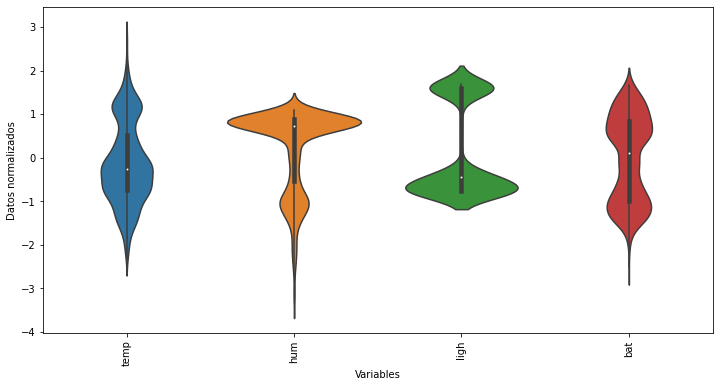

In [73]:
#Distribución del dataset después de normalizar
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Variables', value_name='Datos normalizados')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Variables', y='Datos normalizados', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


Para el entrenamiento del modelo, los datos necesitan ser adaptados de tal forma que se proporcionen unos datos de entrada y se genere una salida (etiqueta).  Los datos de entrada serán las lecturas 'pasadas' y la etiqueta que se asignará corresponderá a la lectura actual del modelo. 

In [74]:
#Funcion que adapta el dataset con entradas y etiquetas (labels)
def series_labeling(data,loopback):
  features_set = [] 
  labels = []
  for i in range(loopback, data.shape[0]):  
      features_set.append(data[i-loopback:i].to_numpy())
      #print(features_set)
      labels.append(data.iloc[i][3])
      #break
  features_set, labels = np.array(features_set), np.array(labels)
  features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], features_set.shape[2]))
  return features_set,labels

In [75]:
#Se adaptan los tres conjuntos
loopback = 6
features_set_train, labels_train = series_labeling(train_df,loopback)
features_set_val, labels_val = series_labeling(val_df,loopback)
features_set_test, labels_test = series_labeling(test_df,loopback)

In [76]:
#Dimensiones de los nuevos conjuntos adaptados
print(features_set_train.shape)
print(features_set_val.shape)
print(features_set_test.shape)

(2052, 6, 4)
(582, 6, 4)
(288, 6, 4)


In [77]:
#Dimensiones de los tensores de entrada
features_set_train[0]

array([[ 1.47562447, -1.28781263, -0.47993472,  1.65713423],
       [ 1.47562447, -1.28781263, -0.47993472,  1.65470924],
       [ 1.47562447, -1.28781263, -0.47993472,  1.65228426],
       [ 1.47562447, -1.28781263, -0.47993472,  1.64985927],
       [ 1.47562447, -1.28781263, -0.44899737,  1.64258431],
       [ 1.31724965, -1.28781263, -0.44899737,  1.63573728]])

In [78]:
#Tamaño que tendrá el batch de entrenamiento
batch_size = (train_df.index[train_df.shape[0]-1] - train_df.index[0]).days
batch_size

14

# Creación y entrenamiento del modelo

###Baseline

In [79]:
#Creación de un baseline para comparar los resultados de los modelos creados
baseline_labels = []
sum = 0
baseline_labels.append(labels_test[0])
for i in range (0,labels_test.shape[0]):
  baseline_labels.append(labels_test[i])

In [80]:
def mse_mae(real_labels,predicted_labels):
  #Cálculo del MSE
  difference_array = np.subtract(np.array(predicted_labels),np.array(real_labels))
  squared_array = np.square(difference_array)
  mse_error = squared_array.mean()
  #Cálculo del MAE
  mae_error = np.abs(np.sum(np.array(predicted_labels)-real_labels))/np.array(real_labels).shape[0]

  return([mse_error,mae_error])

baseline_loss = mse_mae(baseline_labels[:-1],labels_test)
baseline_loss 

[0.000214958864882883, 0.00784109028189954]

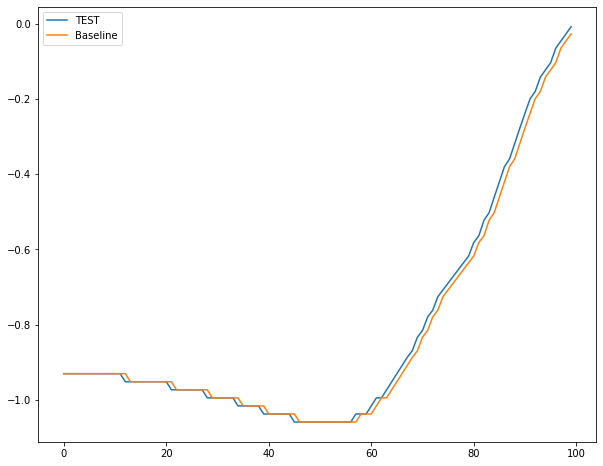

In [81]:
#Se toma como baseline la predicción igual el valor del momento actual.
#Lo que genera un gráfico desplazado en el tiempo.

plt.plot(labels_test[:100],label='TEST')
plt.plot(baseline_labels[:100] ,label='Baseline')
plt.legend()
plt.show()

### Modelo LSTM

Este fue el modelo que se creó inicialmente y que se tuvo que desestimar debido a las limitaciones de TensorFlow Lite para est tipo de redes neuronales

In [82]:
#Creación del modelo
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(32, input_shape=(loopback,num_features)))  #If deep layer 32 is used declare return_sequences=True
#lstm_model.add(tf.keras.layers.Dropout(0.3))
#lstm_model.add(tf.keras.layers.LSTM(32))    
lstm_model.add(tf.keras.layers.Dense(1,kernel_initializer=tf.initializers.zeros()))
lstm_model.compile(loss='mse',optimizer='adam',metrics=['mae'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


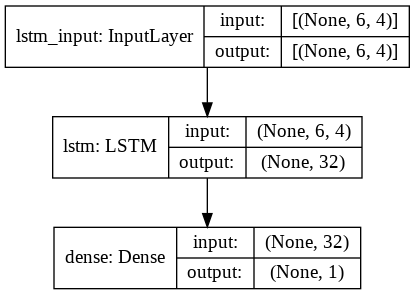

In [83]:
plot_model(lstm_model, to_file=MODELS_DIR+'model_plot/lstm_model_plot.png', show_shapes=True, show_layer_names=True)

In [84]:
# Entrenamiento del lstm_modelo
history_lstm = lstm_model.fit(features_set_train, labels_train, 
                              epochs = 200, 
                              batch_size = batch_size, 
                              validation_data=(features_set_val,labels_val))

Epoch 1/200
147/147 [==============================] - 3s 7ms/step - loss: 0.6458 - mae: 0.6569 - val_loss: 0.0155 - val_mae: 0.1033
Epoch 2/200
147/147 [==============================] - 1s 4ms/step - loss: 0.0219 - mae: 0.0948 - val_loss: 0.0043 - val_mae: 0.0485
Epoch 3/200
147/147 [==============================] - 1s 5ms/step - loss: 0.0164 - mae: 0.0556 - val_loss: 0.0031 - val_mae: 0.0392
Epoch 4/200
147/147 [==============================] - 1s 4ms/step - loss: 0.0130 - mae: 0.0441 - val_loss: 0.0038 - val_mae: 0.0430
Epoch 5/200
147/147 [==============================] - 1s 4ms/step - loss: 0.0144 - mae: 0.0466 - val_loss: 0.0028 - val_mae: 0.0364
Epoch 6/200
147/147 [==============================] - 1s 4ms/step - loss: 0.0148 - mae: 0.0433 - val_loss: 0.0026 - val_mae: 0.0360
Epoch 7/200
147/147 [==============================] - 1s 4ms/step - loss: 0.0162 - mae: 0.0424 - val_loss: 0.0044 - val_mae: 0.0468
Epoch 8/200
147/147 [==============================] - 1s 4ms/step - 

In [85]:
#Se guarda el modelo
lstm_model.save(MODELS_DIR+'lstm_model.h5')

### Modelo CNN

Modelo diseñado para implementar en el microprocesador

In [86]:
# Debido a que la librería de Tensorflow Lite utiliza redes convolucionales Conv2D
# se añadió una dimensión más a los conjuntos de test, val y train

features_set_train_wide = features_set_train.reshape((features_set_train.shape[0], features_set_train.shape[1], features_set_train.shape[2], 1))
features_set_val_wide = features_set_val.reshape((features_set_val.shape[0], features_set_val.shape[1], features_set_val.shape[2], 1))
features_set_test_wide = features_set_test.reshape((features_set_test.shape[0], features_set_test.shape[1], features_set_test.shape[2], 1))

In [87]:
print(features_set_train_wide.shape)
print(features_set_val_wide.shape)
print(features_set_test_wide.shape)

(2052, 6, 4, 1)
(582, 6, 4, 1)
(288, 6, 4, 1)


In [88]:
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2,4),
                                     activation='relu', input_shape=(loopback, num_features,1)))
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu'))
#cnn_model.add(tf.keras.layers.MaxPooling2D((1,1)))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(32, activation='softmax'))
cnn_model.add(tf.keras.layers.Dense(1))


cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 1, 64)          576       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 1, 32)          2080      
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                5152      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________


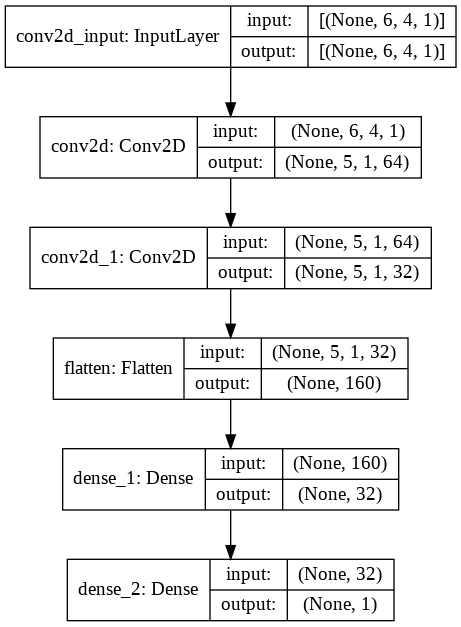

In [89]:
plot_model(cnn_model, to_file=MODELS_DIR+'model_plot/cnn_model_plot.png', show_shapes=True, show_layer_names=True)

In [90]:
# Entrenamiento del modelo
history_cnn = cnn_model.fit(features_set_train_wide, 
                            labels_train, 
                            epochs = 100, 
                            batch_size = batch_size, 
                            validation_data=(features_set_val_wide,labels_val))

Epoch 1/100
147/147 [==============================] - 1s 3ms/step - loss: 0.7278 - mae: 0.7352 - val_loss: 0.2905 - val_mae: 0.4451
Epoch 2/100
147/147 [==============================] - 0s 3ms/step - loss: 0.3102 - mae: 0.4387 - val_loss: 0.1815 - val_mae: 0.3414
Epoch 3/100
147/147 [==============================] - 0s 2ms/step - loss: 0.1999 - mae: 0.3348 - val_loss: 0.1210 - val_mae: 0.2706
Epoch 4/100
147/147 [==============================] - 0s 2ms/step - loss: 0.1341 - mae: 0.2653 - val_loss: 0.0811 - val_mae: 0.2126
Epoch 5/100
147/147 [==============================] - 0s 2ms/step - loss: 0.1000 - mae: 0.2165 - val_loss: 0.0526 - val_mae: 0.1620
Epoch 6/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0753 - mae: 0.1755 - val_loss: 0.0353 - val_mae: 0.1296
Epoch 7/100
147/147 [==============================] - 0s 2ms/step - loss: 0.0581 - mae: 0.1522 - val_loss: 0.0242 - val_mae: 0.1039
Epoch 8/100
147/147 [==============================] - 0s 2ms/step - 

In [91]:
cnn_model.save(MODELS_DIR+'cnn_model.h5')

# Evaluación de los modelos

### Loss y precisión

#### Modelo CNN

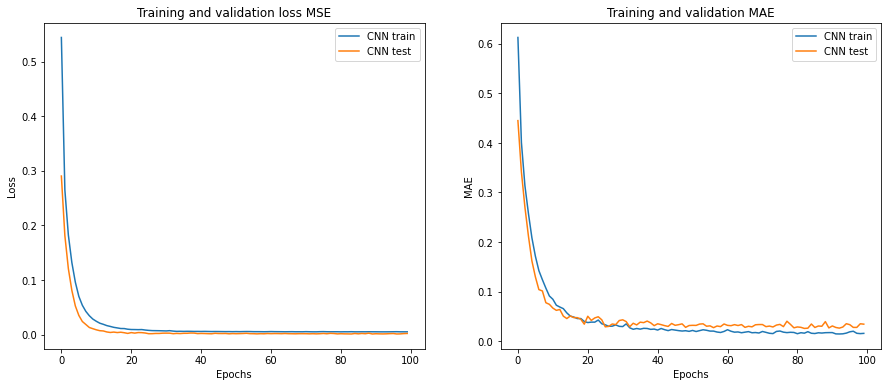

In [93]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='CNN train')
plt.plot(history_cnn.history['val_loss'], label='CNN test')
plt.title('Training and validation loss MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['mae'], label='CNN train')
plt.plot(history_cnn.history['val_mae'], label='CNN test')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# plt.tight_layout()

#### Modelo LSTM

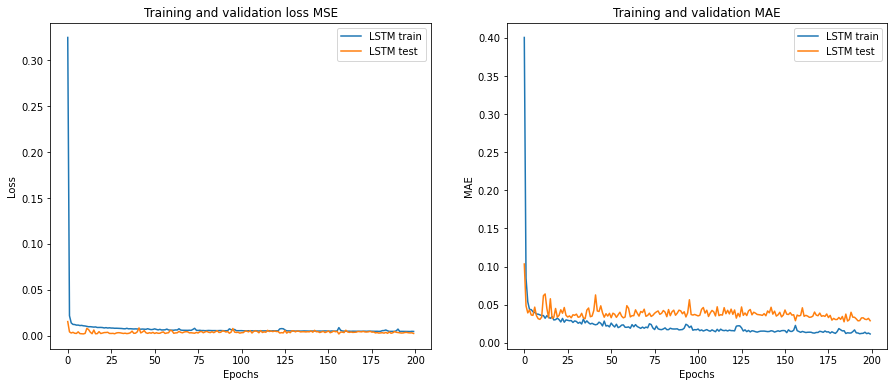

In [92]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM train')
plt.plot(history_lstm.history['val_loss'], label='LSTM test')
plt.title('Training and validation loss MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='LSTM train')
plt.plot(history_lstm.history['val_mae'], label='LSTM test')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Comparación métricas

In [94]:
#Evaluamos los modelos y los comparamos con el baseline
lstm_loss = lstm_model.evaluate(features_set_test,labels_test,verbose=0)
cnn_loss = cnn_model.evaluate(features_set_test_wide,labels_test,verbose=0)

df_loss = pd.DataFrame([baseline_loss,lstm_loss,cnn_loss],columns=['MSE','MAE'],index=["BASELINE","LSTM","CNN"])
df_loss

,MSE,MAE
BASELINE,0.000215,0.007841
LSTM,0.001616,0.030658
CNN,0.003754,0.046306


###Predicciones

#### Modelo CNN

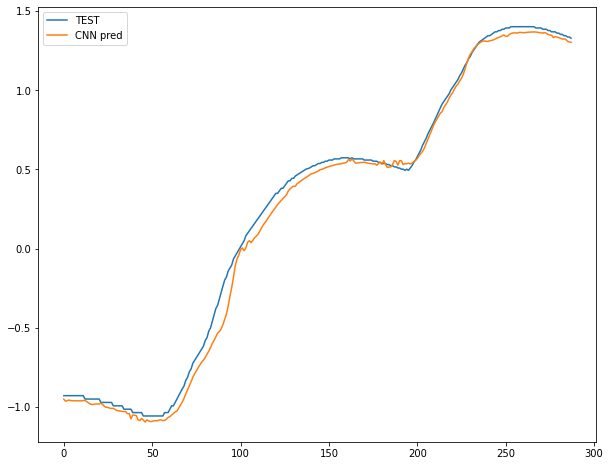

In [95]:
cnn_labels_pred = cnn_model.predict(features_set_test_wide, verbose=0)
plt.plot(labels_test,label='TEST')
plt.plot(cnn_labels_pred,label='CNN pred')
plt.legend()
plt.show()

#### Modelo LSTM

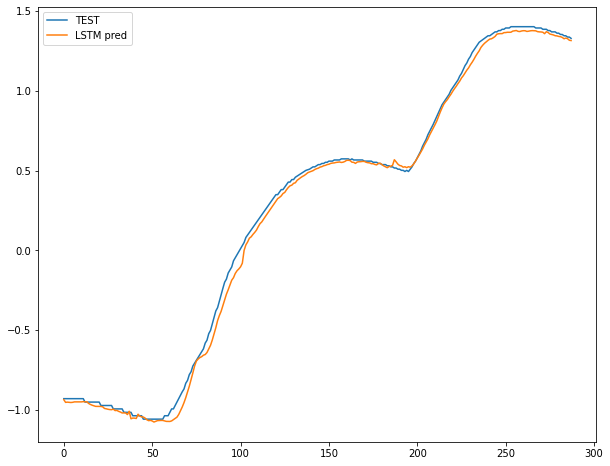

In [96]:
lstm_labels_pred = lstm_model.predict(features_set_test, verbose=0)
plt.plot(labels_test,label='TEST')
plt.plot(lstm_labels_pred,label='LSTM pred')
plt.legend()
plt.show()

# Conversión del modelo CNN a TensorFlow Lite

In [97]:
data_float32 = tf.cast(features_set_test_wide, tf.float32)
tf_data = tf.data.Dataset.from_tensor_slices(data_float32).batch(1)
tf_data

<BatchDataset shapes: (None, 6, 4, 1), types: tf.float32>

In [99]:
def tflite_converter(model):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  #converter = tf.lite.TFLiteConverter.from_keras_model_file(MODELS_DIR+'cnn_model.h5')
  tflite_model = converter.convert()
  return(tflite_model)

def representative_dataset_generator():
  for value in tf_data:
    #print(value.shape)
    yield [value]

def tflite_converter_quantized(model,quantized):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  if quantized == 'yes':  
    converter.representative_dataset = representative_dataset_generator
  # Indicate that we want to perform for size optimizations, which include quantization
  converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
  # Convert the model 
  tflite_model_quantized = converter.convert() 
  return(tflite_model_quantized) 

In [100]:
# Save the model to disk 
open(MODELS_DIR+"cnn_model.tflite","wb").write(tflite_converter(cnn_model))
open(MODELS_DIR+"lstm_model.tflite","wb").write(tflite_converter(lstm_model))

INFO:tensorflow:Assets written to: /tmp/tmps69spbs1/assets


INFO:tensorflow:Assets written to: /tmp/tmpp_3z4g6i/assets


INFO:tensorflow:Assets written to: /tmp/tmpp_3z4g6i/assets


29276

In [101]:
# Save the model to disk 
open(MODELS_DIR+"cnn_model_quantized.tflite","wb").write(tflite_converter_quantized(cnn_model,'yes'))
open("cnn_model_quantized.tflite","wb").write(tflite_converter_quantized(cnn_model,'yes'))

INFO:tensorflow:Assets written to: /tmp/tmp0bbcrq7t/assets


INFO:tensorflow:Assets written to: /tmp/tmp0bbcrq7t/assets


INFO:tensorflow:Assets written to: /tmp/tmpqqsu07db/assets


INFO:tensorflow:Assets written to: /tmp/tmpqqsu07db/assets


15120

In [102]:
# Save the model to disk 
open(MODELS_DIR+"lstm_model_quantized.tflite","wb").write(tflite_converter_quantized(lstm_model,'no'))
open("lstm_model_quantized.tflite","wb").write(tflite_converter_quantized(lstm_model,'no'))

INFO:tensorflow:Assets written to: /tmp/tmpkbhp22j0/assets


INFO:tensorflow:Assets written to: /tmp/tmpkbhp22j0/assets


INFO:tensorflow:Assets written to: /tmp/tmpe_kxoy1f/assets


INFO:tensorflow:Assets written to: /tmp/tmpe_kxoy1f/assets


18000

# Comparación de predicciones entre modelo TF, TF Lite y TF Lite cuantizado

In [103]:
def get_model_size(model,model_tflite,model_tflite_quantized):
  size_tf = os.path.getsize(MODELS_DIR+model)
  size_tflite = os.path.getsize(MODELS_DIR+model_tflite)
  size_tflite_quantized = os.path.getsize(MODELS_DIR+model_tflite_quantized)
  return(size_tf,size_tflite,size_tflite_quantized)

In [104]:
cnn_model_size,cnn_model_lite_size,cnn_model_lite_quant_size = get_model_size('cnn_model.h5','cnn_model.tflite','cnn_model_quantized.tflite')

In [105]:
df_sizes = pd.DataFrame([[cnn_model_size,cnn_model_lite_size,cnn_model_lite_quant_size]],
                        columns = ['TF','TF Lite','TF Lite Q'],
                        index=["CNN"])
df_sizes

,TF,TF Lite,TF Lite Q
CNN,132824,34012,15120


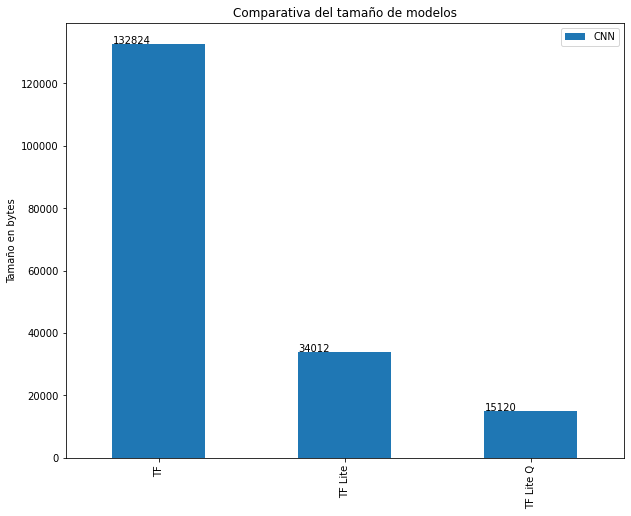

In [106]:
ax = df_sizes.T.plot.bar()
ax.set_title('Comparativa del tamaño de modelos')
ax.set_ylabel('Tamaño en bytes')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))

RNN Quatization issue:

https://github.com/tensorflow/tensorflow/issues/39392

# Evaluación de los modelos convertidos

In [108]:
def tflite_model_prediction(model_file,set_to_predict):
  # Instantiate an interpreter for each model 
  model_lite = tf.lite.Interpreter(model_file) 
  print(model_lite)

  # Allocate memory for each model 
  model_lite.allocate_tensors() 
  # Get indexes of the input and output tensors
  model_input_index = model_lite.get_input_details()[0]["index"] 
  model_output_index = model_lite.get_output_details()[0]["index"] 
  # Create arrays to store the results 
  model_predictions = [] 

  # Run each model's interpreter for each value and store the results in arrays 
  for x_value in set_to_predict: 
      #print(x_value)
      # Create a 3D tensor wrapping the current x value 
      x_value_tensor = tf.convert_to_tensor([x_value], dtype = np.float32)
      #print(x_value_tensor) 
      # Write the value to the input tensor 
      model_lite.set_tensor(model_input_index, x_value_tensor) 
      # Run inference 
      model_lite.invoke() 
      # Read the prediction from the output tensor 
      model_predictions.append(model_lite.get_tensor(model_output_index)[0])
      #print(model_lite.get_tensor(model_output_index)[0])

  operations = model_lite

  model_predictions = np.concatenate(model_predictions, axis=0 ) 
  return(model_predictions,operations)

def denormalize_predictions(test,pred_tf,pred_tflite,pred_tflite_quantized):
  labels_test_denorm = (test*train_std['bat'])+train_mean['bat']
  labels_pred_denorm = (pred_tf*train_std['bat'])+train_mean['bat']
  model_tflite_predictions_denorm = (pred_tflite*train_std['bat'])+train_mean['bat']
  model_tflite_quantized_predictions_denorm = (pred_tflite_quantized*train_std['bat'])+train_mean['bat']
  return(labels_test_denorm,labels_pred_denorm,model_tflite_predictions_denorm,model_tflite_quantized_predictions_denorm)

def plot_predictions(test,pred_tf,pred_tflite,pred_tflite_quantized,model_name):
  plt.clf()
  plt.figure(figsize=(15, 10))
  plt.plot(test,linewidth=4,label='actual')
  plt.plot(pred_tf,linewidth=3,label='original prediction')
  plt.plot(pred_tflite,'ro',label='Lite predictions')
  plt.plot(pred_tflite_quantized,'g.',label='Lite quantized predictions')
  plt.legend()
  title = 'Comparación de predicciones para los modelos ' + model_name
  plt.title(title)
  plt.show()

In [109]:
#Se guardan en CSV los datos de las etiquetas de test y de prediccion del modelo para 
#comparación y evaluación de la aplicación desarrollada en PC
np.savetxt("/content/gdrive/My Drive/Colab Notebooks/TFM/train/constants/labels_test_to_csv.csv",  
           labels_test, 
           delimiter =", ",  
           fmt ='%f') 
#También se guardan los datos que se utilizarán como entrada en la prueba
np.savetxt("/content/gdrive/My Drive/Colab Notebooks/TFM/train/constants/input.csv",  
           features_set_test_wide.reshape(features_set_test_wide.shape[0],features_set_test_wide.shape[1]*features_set_test_wide.shape[2]), 
           delimiter =", ",  
           fmt ='%f') 

In [110]:
cnn_tflite_pred,cnn_tflite_oper = tflite_model_prediction(MODELS_DIR+'cnn_model.tflite',features_set_test_wide)
cnn_tflite_quant_pred,cnn_tflite_quant_oper = tflite_model_prediction(MODELS_DIR+'cnn_model_quantized.tflite',features_set_test_wide)

In [111]:
lstm_tflite_pred,lstm_tflite_oper = tflite_model_prediction(MODELS_DIR+'lstm_model.tflite',features_set_test)
lstm_tflite_quant_pred,lstm_tflite_quant_oper = tflite_model_prediction(MODELS_DIR+'lstm_model_quantized.tflite',features_set_test)

In [112]:
#Se guardan en CSV los datos de las etiquetas de test y de prediccion del modelo para 
#comparación y evaluación de la aplicación desarrollada en PC
np.savetxt("/content/gdrive/My Drive/Colab Notebooks/TFM/train/constants/predictions_to_csv.csv",  
           cnn_tflite_quant_pred, 
           delimiter =", ",  
           fmt ='%f') 

In [113]:
#Datos del vector de entrada
cnn_tflite_quant_oper.get_input_details()

[{'dtype': numpy.float32,
  'index': 16,
  'name': 'conv2d_input',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 6, 4, 1], dtype=int32),
  'shape_signature': array([-1,  6,  4,  1], dtype=int32),
  'sparsity_parameters': {}}]

<Figure size 720x576 with 0 Axes>

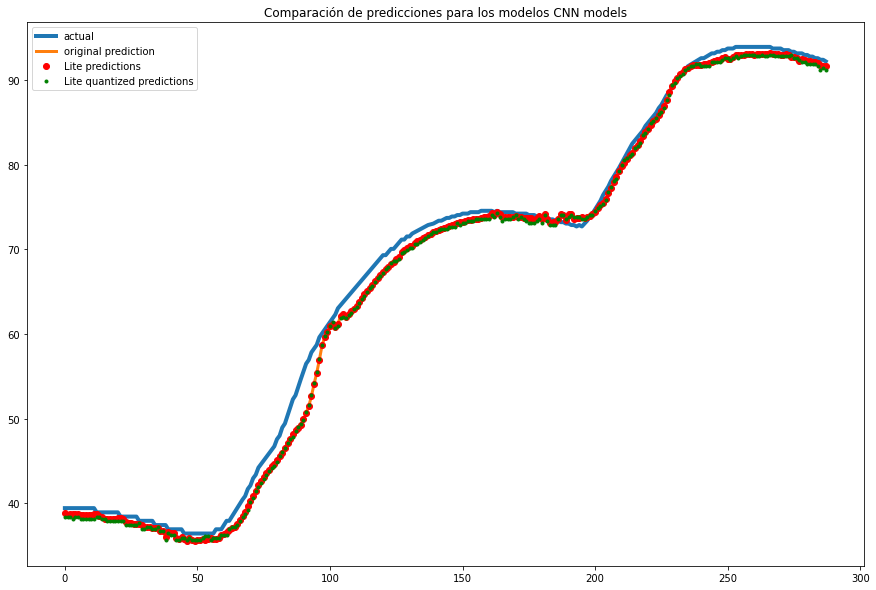

In [114]:
original,cnn_tf_original,cnn_tflite_original,cnn_tflite_original_quant = denormalize_predictions(labels_test,cnn_labels_pred,cnn_tflite_pred,cnn_tflite_quant_pred)
plot_predictions(original,cnn_tf_original,cnn_tflite_original,cnn_tflite_original_quant,'CNN models')

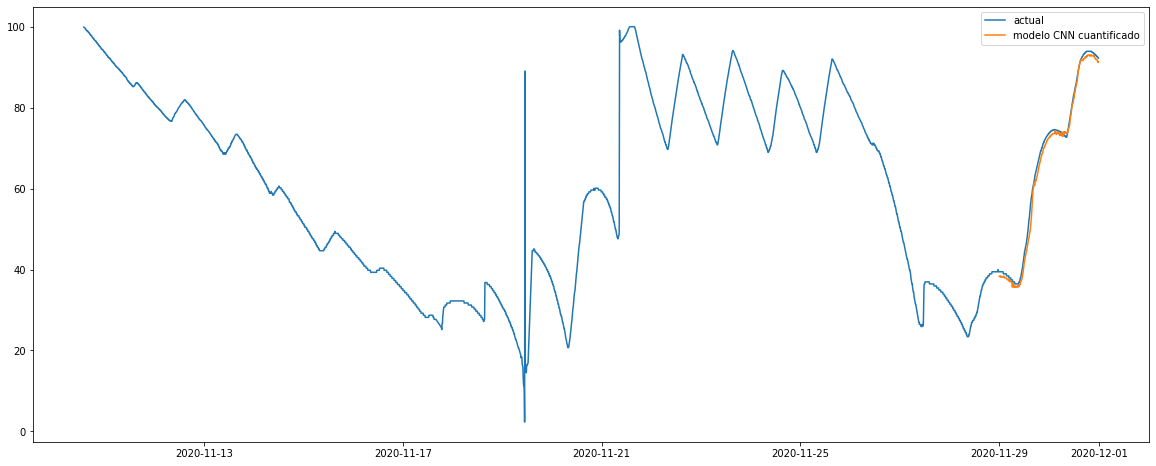

In [116]:
plt.figure(figsize=(20,8))
plt.plot(df['bat'], label='actual')
plt.plot(test_df.index[loopback:], cnn_tflite_original_quant, label='modelo CNN cuantificado')
plt.legend()

# Conversión del modelo a un fichero C

In [117]:
# Install xxd if it is not available 
!apt-get -qq install xxd 
# Save the file as a C source file 
!xxd -i cnn_model_quantized.tflite > cnn_model_quantized.cc 

In [118]:
# Print the source file 
!cat cnn_model_quantized.cc

unsigned char cnn_model_quantized_tflite[] = {
  0x28, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x54, 0x3a, 0x00, 0x00, 0x04, 0x22, 0x00, 0x00, 0xec, 0x21, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x04, 0x00, 0x08, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x11, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x12, 0x00, 0x00, 0x00, 0xa0, 0x21, 0x00, 0x00, 0x8c, 0x21, 0x00, 0x00,
  0x70, 0x20, 0x00, 0x00, 0xdc, 0x1f, 0x00, 0x00, 0x48, 0x1f, 0x00, 0x00,
  0x34, 0x1f, 0x00, 0x00, 0x10, 0x1f, 0x00, 0x00, 0xfc, 0x0a, 0x0

# Visualización de las inferencias de test en PC

Las inferencias hechas por la aplicación en el ordenador se han exportado y traído como CSV al Notebook para comparar gráficamente.

In [119]:
from numpy import genfromtxt
inference_list = genfromtxt('/content/gdrive/My Drive/Colab Notebooks/TFM/train/constants/inferencias.csv', delimiter=',')

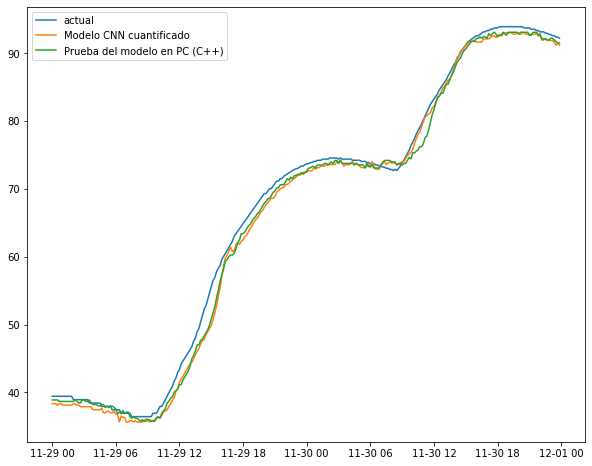

In [120]:
plt.plot(df['bat'][-288:], label='actual')
plt.plot(test_df.index[loopback:], cnn_tflite_original_quant, label='Modelo CNN cuantificado')
plt.plot(test_df.index[loopback:],inference_list,label='Prueba del modelo en PC (C++)')
plt.legend()
plt.show()

In [122]:
inf_loss = mse_mae(labels_test,(inference_list-train_mean['bat'])/train_std['bat'])
cnn_quant_loss = mse_mae(labels_test,cnn_tflite_quant_pred)


In [124]:
df_loss = pd.DataFrame([baseline_loss,cnn_loss,cnn_quant_loss,inf_loss],columns=['MSE','MAE'],index=["BASELINE","CNN","CNN_QUANT","CNN_QUANT_PC"])
df_loss

,MSE,MAE
BASELINE,0.000215,0.007841
CNN,0.003754,0.046306
CNN_QUANT,0.004224,0.048655
CNN_QUANT_PC,0.003689,0.042693


# Referencias

* https://www.tensorflow.org/lite/microcontrollers  
* https://www.tensorflow.org/lite/microcontrollers/build_convert#model_conversion 
* https://www.tensorflow.org/tutorials/structured_data/time_series
* https://towardsdatascience.com/time-series-forecasting-with-2d-convolutions-4f1a0f33dff6
* https://www.irnas.eu/creating-simple-keras-model-for-inference-on-microcontrollers/


 
